![Image of Vizsla](https://storage.googleapis.com/kaggle-competitions/kaggle/7327/logos/header.png)

# Dog Breed Identification -  Part 2 - CNN From Scratch

First of all, in order to create a graph for the data we need to convert all images to the same dimensions
All images are taken from the ImageNet dataset, hence we can use similar convertion techniques and expect good results.

## Validation Strategy

I created a Validation Dataset by chosing randomly 20% samples of data of each class, in order to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

## Creating Model

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint

import keras.backend as K
K.set_image_data_format('channels_last')

# dimensions of our images.
img_width, img_height = 224,224


train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 10
batch_size = 20

input_shape = (img_width, img_height, 3)
    
print("input_shape:",input_shape)

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(120, activation='softmax'))

model.summary()

input_shape: (224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 54, 54, 32)  

## A few words about the structure:

I used BatchNormalization, 5 blocks with Conv2D, MaxPooling2D and BatchNormalization layers, and a GlobalAveragePooling2D and Dense at last.

I normalize the input layer by adjusting and scaling the activations. Also, batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.
It also reduces overfitting because it has regularization effects.

## Compiling the model:

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        featurewise_center=True,
        featurewise_std_normalization=True
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    
)


# for validation we will use only rescaling
test_datagen = ImageDataGenerator(featurewise_center=True,
        featurewise_std_normalization=True)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

from time import gmtime, strftime
time = strftime("%Y.%m.%d.%H%M%S", gmtime())

tensor_board = TensorBoard(f'./logs/DogBreedAnn{time}')

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.bestaugmented.from_scratchT{time}.hdf5', 
                               verbose=1, save_best_only=True)



Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


# Training model in Increasing batches 

After a couple of tries we decided to train our model in increased batches, we expect it to first learn big differences between breeds and then with bigger batches generalize more

We also added ModelCheckpoint here so between runs we will take the best model and not the overfitted one

In [ ]:
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

## more training...

In [8]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 20
epochs = 5

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/5
408/408 [==============================] - 176s 432ms/step - loss: 3.0810 - acc: 0.2522 - val_loss: 3.5542 - val_acc: 0.1887

Epoch 00001: val_loss improved from 3.58153 to 3.55422, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/5
408/408 [==============================] - 173s 424ms/step - loss: 2.9910 - acc: 0.2667 - val_loss: 3.4592 - val_acc: 0.2085

Epoch 00002: val_loss improved from 3.55422 to 3.45920, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 3/5
408/408 [==============================] - 173s 424ms/step - loss: 2.9084 - acc: 0.2900 - val_loss: 3.6599 - val_acc: 0.1877

Epoch 00003: val_loss did not improve from 3.45920
Epoch 4/5
408/408 [==============================] - 178s 435ms/step - loss: 2.8280 - acc: 0.3059 - val_loss: 3.5285 - val_acc: 0.1966

Epoch 00004: val_loss did not improve from 3.45920
Epoch 5/5
408/408 [==============================] - 167s 409ms/step - loss: 2.7512 - acc: 0.3241 - val_

## Another try of training:

In [9]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 20
epochs = 10

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/10
408/408 [==============================] - 179s 438ms/step - loss: 2.6693 - acc: 0.3386 - val_loss: 3.1596 - val_acc: 0.2614

Epoch 00001: val_loss improved from 3.33954 to 3.15962, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/10
408/408 [==============================] - 171s 419ms/step - loss: 2.6168 - acc: 0.3426 - val_loss: 3.3163 - val_acc: 0.2208

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/10
408/408 [==============================] - 175s 430ms/step - loss: 2.5380 - acc: 0.3614 - val_loss: 3.3495 - val_acc: 0.2312

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/10
408/408 [==============================] - 171s 419ms/step - loss: 2.4734 - acc: 0.3797 - val_loss: 3.2347 - val_acc: 0.2544

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/10
408/408 [==============================] - 168s 411ms/step - loss: 2.4271 - acc: 0.3871 - val_loss: 3.2410 - val_acc: 0.2564

Epoch 00005: val_loss did not improve

## And Again..

Note: Here we are changing the batch size to 32, after the model didn't learn from 10 epochs with a batch of size 10.

In [10]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 32
epochs = 10

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/10
255/255 [==============================] - 112s 438ms/step - loss: 2.5368 - acc: 0.3657 - val_loss: 3.3320 - val_acc: 0.2042

Epoch 00001: val_loss did not improve from 3.15962
Epoch 2/10
255/255 [==============================] - 106s 417ms/step - loss: 2.5519 - acc: 0.3585 - val_loss: 3.2460 - val_acc: 0.2267

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/10
255/255 [==============================] - 108s 425ms/step - loss: 2.5279 - acc: 0.3682 - val_loss: 3.4061 - val_acc: 0.2143

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/10
255/255 [==============================] - 107s 420ms/step - loss: 2.4492 - acc: 0.3798 - val_loss: 3.5682 - val_acc: 0.2251

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/10
255/255 [==============================] - 107s 421ms/step - loss: 2.4862 - acc: 0.3711 - val_loss: 3.1995 - val_acc: 0.2603

Epoch 00005: val_loss did not improve from 3.15962
Epoch 6/10
255/255 [==============================] - 110s 4

## Epoch++
The Model didnt learn anything from the last 10 epochs with batch size of 32 so we decided to give it more epochs and continue to bigger batches

In [11]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 32
epochs = 30

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/30
255/255 [==============================] - 114s 446ms/step - loss: 2.5512 - acc: 0.3655 - val_loss: 3.2844 - val_acc: 0.2275

Epoch 00001: val_loss did not improve from 3.15962
Epoch 2/30
255/255 [==============================] - 105s 410ms/step - loss: 2.5050 - acc: 0.3729 - val_loss: 3.3629 - val_acc: 0.2500

Epoch 00002: val_loss did not improve from 3.15962
Epoch 3/30
255/255 [==============================] - 103s 404ms/step - loss: 2.5412 - acc: 0.3623 - val_loss: 3.5617 - val_acc: 0.2190

Epoch 00003: val_loss did not improve from 3.15962
Epoch 4/30
255/255 [==============================] - 105s 413ms/step - loss: 2.5316 - acc: 0.3675 - val_loss: 3.4254 - val_acc: 0.2476

Epoch 00004: val_loss did not improve from 3.15962
Epoch 5/30
255/255 [==============================] - 105s 412ms/step - loss: 2.4370 - acc: 0.3893 - val_loss: 3.2567 - val_acc: 0.2508

Epoch 00005: val_loss did not improve from 3.15962
Epoch 6/30
255/255 [==============================] - 107s 4

## Grand finalle

And for the Grand finalle, 100 epochs with 100 batch size, if some feature is learnable now it will be learned.
We expect our model to overfit the data from now on but we also hope to gain better results from that overfitting

In [14]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

batch_size = 100
epochs = 100

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/100
81/81 [==============================] - 35s 428ms/step - loss: 1.9240 - acc: 0.5037 - val_loss: 3.4306 - val_acc: 0.1975

Epoch 00001: val_loss did not improve from 2.90440
Epoch 2/100
81/81 [==============================] - 36s 445ms/step - loss: 2.0023 - acc: 0.4735 - val_loss: 3.0018 - val_acc: 0.2825

Epoch 00002: val_loss did not improve from 2.90440
Epoch 3/100
81/81 [==============================] - 32s 396ms/step - loss: 1.9997 - acc: 0.4788 - val_loss: 2.9814 - val_acc: 0.2775

Epoch 00003: val_loss did not improve from 2.90440
Epoch 4/100
81/81 [==============================] - 32s 400ms/step - loss: 2.0307 - acc: 0.4660 - val_loss: 3.3805 - val_acc: 0.2370

Epoch 00004: val_loss did not improve from 2.90440
Epoch 5/100
81/81 [==============================] - 32s 390ms/step - loss: 1.9369 - acc: 0.4938 - val_loss: 3.6155 - val_acc: 0.2325

Epoch 00005: val_loss did not improve from 2.90440
Epoch 6/100
81/81 [==============================] - 32s 397ms/step - 

81/81 [==============================] - 31s 386ms/step - loss: 1.6516 - acc: 0.5525 - val_loss: 3.2831 - val_acc: 0.3275

Epoch 00044: val_loss did not improve from 2.88684
Epoch 45/100
81/81 [==============================] - 31s 384ms/step - loss: 1.7062 - acc: 0.5364 - val_loss: 3.5468 - val_acc: 0.2526

Epoch 00045: val_loss did not improve from 2.88684
Epoch 46/100
81/81 [==============================] - 32s 395ms/step - loss: 1.7826 - acc: 0.5142 - val_loss: 3.4545 - val_acc: 0.2675

Epoch 00046: val_loss did not improve from 2.88684
Epoch 47/100
81/81 [==============================] - 32s 392ms/step - loss: 1.7809 - acc: 0.5179 - val_loss: 4.0357 - val_acc: 0.2100

Epoch 00047: val_loss did not improve from 2.88684
Epoch 48/100
81/81 [==============================] - 32s 390ms/step - loss: 1.6743 - acc: 0.5507 - val_loss: 3.2727 - val_acc: 0.3150

Epoch 00048: val_loss did not improve from 2.88684
Epoch 49/100
81/81 [==============================] - 32s 395ms/step - loss: 1

81/81 [==============================] - 31s 388ms/step - loss: 1.5811 - acc: 0.5623 - val_loss: 3.9794 - val_acc: 0.2625

Epoch 00088: val_loss did not improve from 2.88684
Epoch 89/100
81/81 [==============================] - 31s 385ms/step - loss: 1.4837 - acc: 0.5882 - val_loss: 3.7483 - val_acc: 0.2575

Epoch 00089: val_loss did not improve from 2.88684
Epoch 90/100
81/81 [==============================] - 31s 386ms/step - loss: 1.4383 - acc: 0.6086 - val_loss: 3.1007 - val_acc: 0.3750

Epoch 00090: val_loss did not improve from 2.88684
Epoch 91/100
81/81 [==============================] - 31s 381ms/step - loss: 1.4973 - acc: 0.5846 - val_loss: 4.0561 - val_acc: 0.2525

Epoch 00091: val_loss did not improve from 2.88684
Epoch 92/100
81/81 [==============================] - 31s 384ms/step - loss: 1.5288 - acc: 0.5809 - val_loss: 3.6671 - val_acc: 0.2604

Epoch 00092: val_loss did not improve from 2.88684
Epoch 93/100
81/81 [==============================] - 32s 392ms/step - loss: 1

## Lets see some metrics

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


We want to analyse the Confusion matrix in order to understand where the model is failing and how can we improve it:

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 4

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

test_generator.reset()
predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size) )


ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


Found 2044 images belonging to 120 classes.
                                precision    recall  f1-score   support

                 affenpinscher       0.80      0.24      0.36        17
                  afghan_hound       0.23      0.41      0.30        17
           african_hunting_dog       0.33      0.24      0.28        17
                      airedale       0.23      0.18      0.20        17
american_staffordshire_terrier       0.06      0.06      0.06        17
                   appenzeller       0.27      0.18      0.21        17
            australian_terrier       0.29      0.24      0.26        17
                       basenji       0.18      0.41      0.25        17
                        basset       0.20      0.12      0.15        17
                        beagle       0.24      0.41      0.30        17
            bedlington_terrier       0.26      0.53      0.35        17
          bernese_mountain_dog       0.30      0.53      0.38        17
       black-and-ta

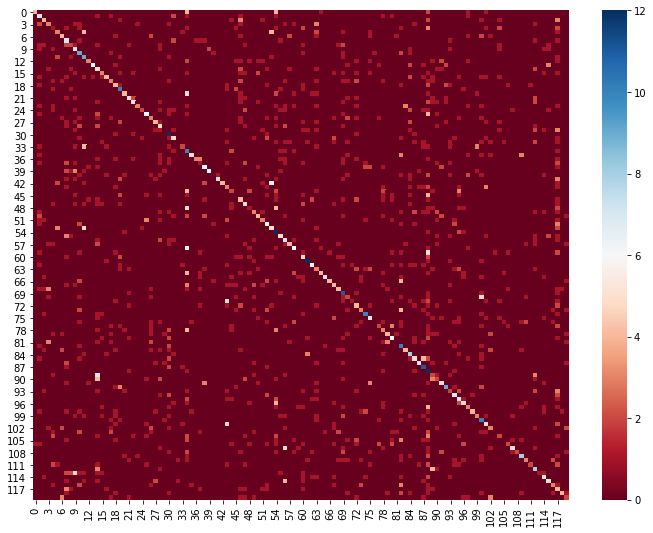

In [13]:
plt.figure(figsize=(12,9))
sns.heatmap(data = conf,cmap='RdBu')

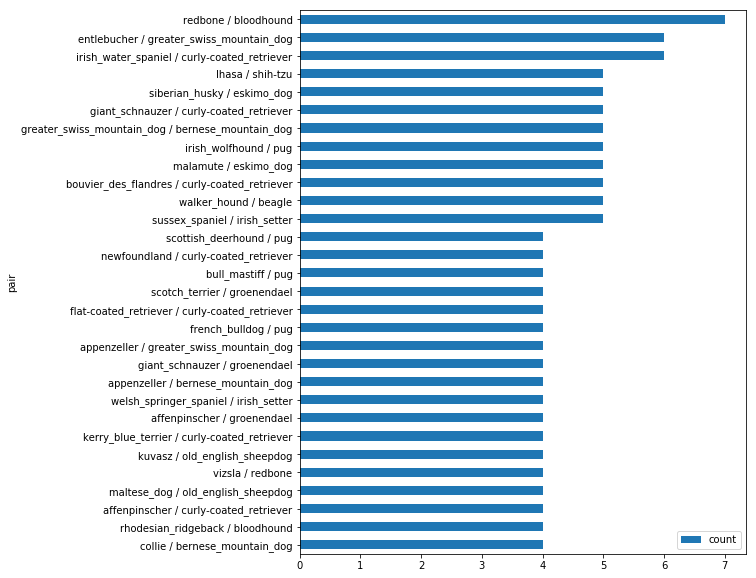

In [14]:
import pandas as pd

labelNames = [target_names[x] for x in test_generator.classes]
ClassPredictionsNames = [target_names[x] for x in ClassPredictions]

d = {'actual':labelNames , 'pred':ClassPredictionsNames}
df = pd.DataFrame(d)

df['count'] = 1

misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()

misclass_df['pair'] = misclass_df['actual'].astype(str) + ' / ' + misclass_df['pred'].astype(str)

misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')

We see that the biggest mismatch is Redbone and Blood hound, the second is Greater Swiss Mountain Dog and Entlebucher.

We noticed that the first mismatch is between breeds that a human being will be able to separate. Therefore, we conlclude that our model is not performing very well, and there are still more features to learn.

The second mismatch is between breeds which are very similar and most of the humans wont distinguish between them, so maybe our model is not so bad after all.

Here are pictures of the spoken dogos:

## redbone:

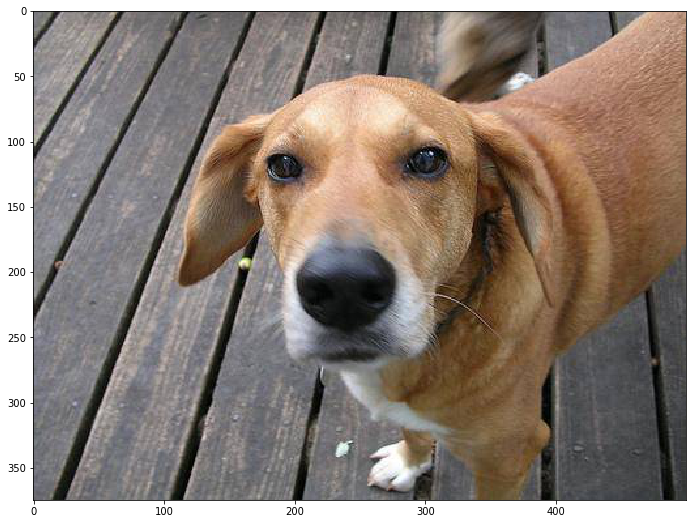

In [18]:
plt.figure(figsize=(12,9))
img=mpimg.imread('../DogBreedDataSet/valid/redbone/b220bfa6780f5e36871117680bed8b03.jpg')
imgplot = plt.imshow(img)
plt.show()

## bloodhound:

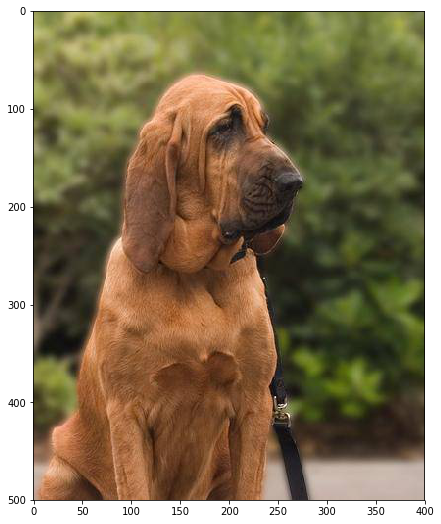

In [23]:
plt.figure(figsize=(12,9))
img=mpimg.imread('../DogBreedDataSet/train/bloodhound/593991d6febd36e8b0c0730c93768d5a.jpg')
imgplot = plt.imshow(img)
plt.show()

## Entlebucher:

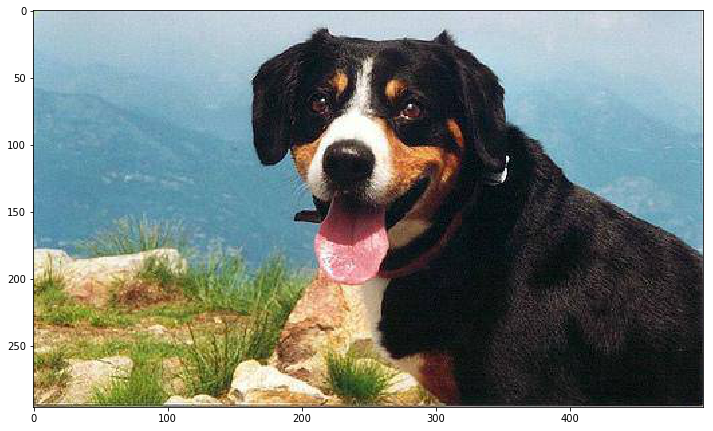

In [24]:
plt.figure(figsize=(12,9))
img=mpim## bloodhound:g.imread('../DogBreedDataSet/train/entlebucher/3a896e59b44a11f008113c6c8fd1cd7b.jpg')
imgplot = plt.imshow(img)
plt.show()

## Greater Swiss Mountain Dog:

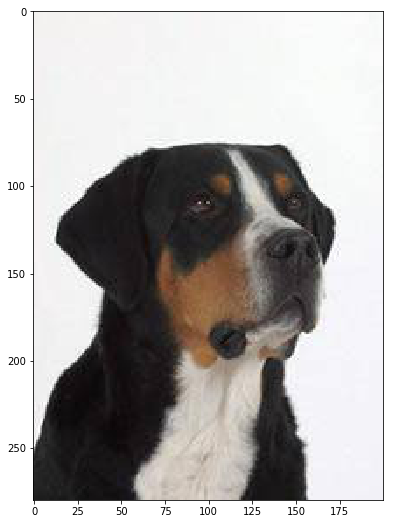

In [25]:
plt.figure(figsize=(12## entlebucher:,9))
img=mpimg.imread('../DogBreedDataSet/train/greater_swiss_mountain_dog/0177a92a906192bfde8adbb8a237e524.jpg')
imgplot = plt.imshow(img)
plt.show()

## Middle Thinking

Lets try to figure out where & why is the model misclassifying and suggest ways to improve the results:

-Lose a layer in order to to have a more generelized model:
We get a lot parameters in the model, while the dataset contains about 10000 images. Even after augmenting the images and increasing the dataset size, the model has relatively high amount of parameters. Decreasing this amount will lead us to a more generilized model. We can try this by losing a conv layer.

-Clean validation:
We see that we get lower results for the validation set. Perhaps, the images in this set are not clean, and we should ensure the data is suitable.

-Lose bias in data:
We see that there is a significant difference in the amount of images there are per classes: there is a class with about 120 images, and on the other hand there is another class with just 60-70 images. 
This difference add unnatural bias to our model as the date is not balanced vey well: as we have more images of a specific class, we may classidy more images to this class just baecause there is more data in that class. 

-Bigger batches:
We strated at batch size of 20 and we saw that it 
We used image generator for images by Keras. We created 20 augmented images out of each image in order to increase out Dataset. We used the 'flow from directory' generator which made this proccess more efficient for the GPU. 
We saw that the result were not so great, so we decided to increase the batch size to 30, 40 and 50. We saw an imporvment in the results that we got.

-Image size:
We also tried changing the image size (power of 2). We saw an improvement in the training speed and eventualy chose the size of 224X224 which showed the best results.

-Dropouts:
We see that our model is overfitting as the accuracy of the training dataset is 80% but the accuracy of the validation datatset is only about 25-30%. We know that dropouts may help with the overfitting problem by making the model's weights more robust for the generalized problem.

-Clean data:
Most of the images show the dogs in defferent scales and resolutions. They also contain clutter and noise such as trees, humans, and various items in the background. This may harm the abbility of the model to perform a quality training. 
We may try and solve it by manualy going over the images and exluding the ones that conatin a lot of noise and will not contribute to the learning proccess. 

-Normalization:
Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate). Currently we just rescaled the samples by 255 to set the data values between 0 and 1. In order to make the model converge faster, we would like to set the mean of the data to 0, and standart deviation of 1. We can do that by substructing the mean pixel from the dataset, and deviding by the standart deviation. Subtracting the mean centers the input to 0, and dividing by the standard deviation makes any scaled feature value the number of standard deviations away from the mean.


I decided to prioritize and implement Dropouts and Normalization.

## Now with Dropouts and Normalization.

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint

import keras.backend as K
K.set_image_data_format('channels_last')

# dimensions of our images.
img_width, img_height = 224,224


train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
nb_train_samples = 8178
nb_validation_samples = 2044

batch_size = 20

input_shape = (img_width, img_height, 3)
    
print("input_shape:",input_shape)

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5)) 

model.add(Dense(120, activation='softmax'))

model.summary()

Using TensorFlow backend.


input_shape: (224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)  

In [2]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest', 
)

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(featurewise_center=True,
        featurewise_std_normalization=True)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

from time import gmtime, strftime
time = strftime("%Y.%m.%d.%H%M%S", gmtime())

tensor_board = TensorBoard(f'./logs/DogBreedScratchAnnDropouts{time}')

checkpointer = ModelCheckpoint(filepath=f'saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5', 
                               verbose=1, save_best_only=True)


Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [3]:
epochs = 140

# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,checkpointer],
    verbose=1
)   

Epoch 1/140
408/408 [==============================] - 180s 441ms/step - loss: 4.8484 - acc: 0.0207 - val_loss: 4.6158 - val_acc: 0.0387

Epoch 00001: val_loss improved from inf to 4.61583, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 2/140
408/408 [==============================] - 213s 521ms/step - loss: 4.5676 - acc: 0.0399 - val_loss: 4.4495 - val_acc: 0.0504

Epoch 00002: val_loss improved from 4.61583 to 4.44951, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 3/140
408/408 [==============================] - 172s 421ms/step - loss: 4.4204 - acc: 0.0483 - val_loss: 4.3108 - val_acc: 0.0548

Epoch 00003: val_loss improved from 4.44951 to 4.31079, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 4/140
408/408 [==============================] - 165s 406ms/step - loss: 4.2726 - acc: 0.0624 - val_loss: 4.1982 - val_acc: 0.0741

Epoch 00004: val_loss improved from 4.31079 to 4.19818, saving model to sa

408/408 [==============================] - 184s 451ms/step - loss: 2.6515 - acc: 0.3222 - val_loss: 3.0263 - val_acc: 0.2747

Epoch 00036: val_loss improved from 3.03217 to 3.02630, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 37/140
408/408 [==============================] - 166s 407ms/step - loss: 2.6130 - acc: 0.3341 - val_loss: 3.2783 - val_acc: 0.2624

Epoch 00037: val_loss did not improve from 3.02630
Epoch 38/140
408/408 [==============================] - 176s 431ms/step - loss: 2.6314 - acc: 0.3308 - val_loss: 3.0839 - val_acc: 0.2693

Epoch 00038: val_loss did not improve from 3.02630
Epoch 39/140
408/408 [==============================] - 193s 473ms/step - loss: 2.5783 - acc: 0.3437 - val_loss: 2.9538 - val_acc: 0.2950

Epoch 00039: val_loss improved from 3.02630 to 2.95384, saving model to saved_models/weights.DogBreedScratchAnnDropoutsT.hdf5
Epoch 40/140
408/408 [==============================] - 177s 433ms/step - loss: 2.5692 - acc: 0.3487 - 

408/408 [==============================] - 161s 394ms/step - loss: 1.8678 - acc: 0.5017 - val_loss: 2.7357 - val_acc: 0.3617

Epoch 00119: val_loss did not improve from 2.64842
Epoch 120/140
408/408 [==============================] - 160s 391ms/step - loss: 1.8762 - acc: 0.4961 - val_loss: 2.7933 - val_acc: 0.3597

Epoch 00120: val_loss did not improve from 2.64842
Epoch 121/140
408/408 [==============================] - 161s 395ms/step - loss: 1.8763 - acc: 0.4952 - val_loss: 2.7606 - val_acc: 0.3503

Epoch 00121: val_loss did not improve from 2.64842
Epoch 122/140
408/408 [==============================] - 160s 392ms/step - loss: 1.8535 - acc: 0.5020 - val_loss: 2.7461 - val_acc: 0.3567

Epoch 00122: val_loss did not improve from 2.64842
Epoch 123/140
408/408 [==============================] - 160s 393ms/step - loss: 1.8766 - acc: 0.4899 - val_loss: 2.8031 - val_acc: 0.3671

Epoch 00123: val_loss did not improve from 2.64842
Epoch 124/140
408/408 [==============================] - 16

## A few words about the improvement:

After adding dropouts and normalizing better, we saw an improvement – we managed to get a 37% accuracy score on the validation set and val_loss of 2.7393 which is not good but still an improvment from 2.88684.
Maybe adding another dense layer and another dropuot layer before our softmax classification layer could help reduce val_loss more and make our model more generalized.